<a href="https://colab.research.google.com/github/Leptons-Multiconcept/fixam-sales-forecast/blob/main/SalesForecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
store_sales = pd.read_csv('//content/sales_forecast.csv')
store_sales.head(10)

,date,store,item,sales
0,01/01/2013,1,1,13
1,02/01/2013,1,1,11
2,03/01/2013,1,1,14
3,04/01/2013,1,1,13
4,05/01/2013,1,1,10
5,06/01/2013,1,1,12
6,07/01/2013,1,1,10
7,08/01/2013,1,1,9
8,09/01/2013,1,1,12
9,10/01/2013,1,1,9


In [ ]:
# check for null values
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [ ]:
# dropping store and item columns
store_sales = store_sales.drop(['store', 'item'], axis=1)

In [ ]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   sales   913000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 13.9+ MB


In [ ]:
# Converting date from object to datetime datatime
store_sales['date'] = pd.to_datetime(store_sales['date'], dayfirst=True)

In [ ]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.9 MB


In [ ]:
# Converting date to month period and then sum the number of items in each month
store_sales['date'] = store_sales['date'].dt.to_period('M')
monthly_sales = store_sales.groupby('date').sum().reset_index()

In [ ]:
# Convert the resulting date to timestamp datatype
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()


In [ ]:
monthly_sales.head(10)

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242
5,2013-06-01,795597
6,2013-07-01,855922
7,2013-08-01,766761
8,2013-09-01,689907
9,2013-10-01,656587


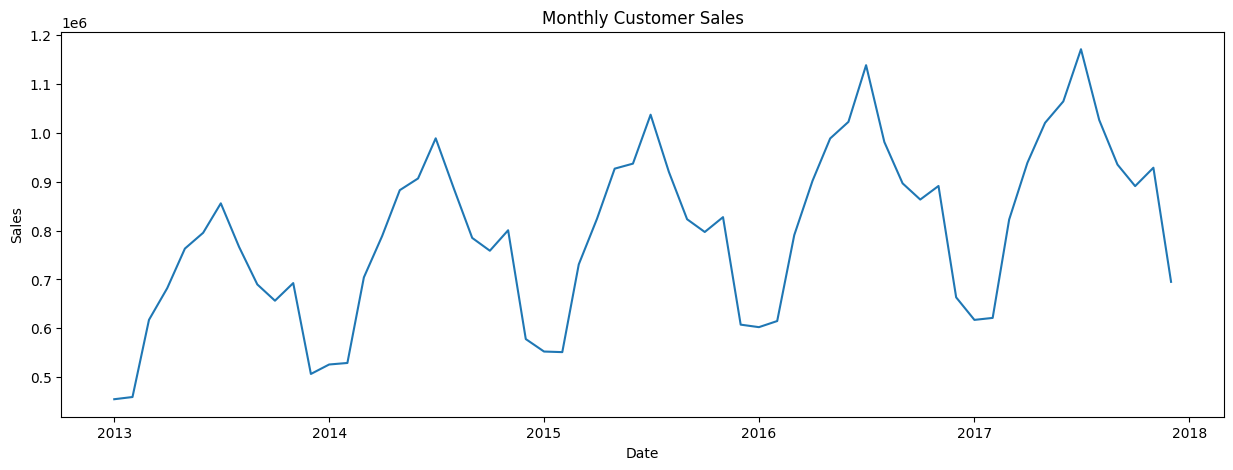

In [ ]:
# Visualization
plt.figure(figsize=(15, 5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Monthly Customer Sales')
plt.show()

In [ ]:
# Call the difference on the sales to make the sales data stationary
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0
6,2013-07-01,855922,60325.0
7,2013-08-01,766761,-89161.0
8,2013-09-01,689907,-76854.0
9,2013-10-01,656587,-33320.0
10,2013-11-01,692643,36056.0


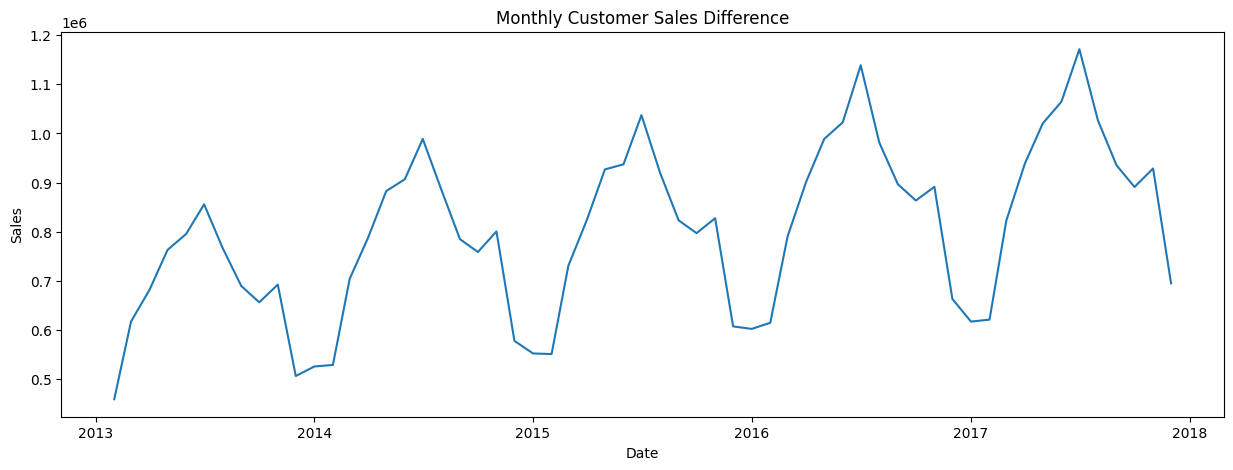

In [ ]:
# Visualization
plt.figure(figsize=(15, 5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Monthly Customer Sales Difference')
plt.show()

In [ ]:
# Dropping odd sales and data
supervised_data = monthly_sales.drop(['date', 'sales'], axis=1)

In [ ]:
# Preparing the supervised data
for i in range(1,13):
  col_name = 'month_' + str(i)
  supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


In [ ]:
# Spltting the data into train and test
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]
print('Train Data Shape: ', train_data.shape)
print('Test Data Shape: ', test_data.shape)

Train Data Shape:  (35, 13)
Test Data Shape:  (12, 13)


In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [ ]:
x_train, y_train = train_data[:, 1:], train_data[:, 0:1]
x_test, y_test = test_data[:, 1:], test_data[:, 0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print('x_train shape: ', x_train.shape)
print('y_train shape: ', y_train.shape)
print('x_test shape: ', x_test.shape)
print('y_test shape: ', y_test.shape)

x_train shape:  (35, 12)
y_train shape:  (35,)
x_test shape:  (12, 12)
y_test shape:  (12,)


In [ ]:
# Making a prediction dataframe to merge the predicted sale prices of all trained algorithms
sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)

In [ ]:
act_sales = monthly_sales['sales'][-13:].to_list()
print(act_sales)

[663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170]


Forecast Sales using Linear Regression

In [ ]:
# Create the Linear Regression Model and the Predicted output
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
lr_pred = lr_model.predict(x_test)

In [ ]:
lr_pred = lr_pred.reshape(-1, 1)
# This is a test matrix. Contains the input features of the test data and also the predicted output
lr_pred_test_set = np.concatenate([lr_pred, x_test], axis=1)
lr_pred_test_set = scaler.inverse_transform(lr_pred_test_set)


In [ ]:
result_list = []
for index in range(len(lr_pred_test_set)):
  result_list.append(lr_pred_test_set[index][0] + act_sales[index])
lr_pred_series = pd.Series(result_list, name='Linear Prediction')
predict_df = predict_df.merge(lr_pred_series, left_index=True, right_index=True)

In [ ]:
print(predict_df)

         date  Linear Prediction
0  2017-01-01       6.479148e+05
1  2017-02-01       6.283374e+05
2  2017-03-01       8.195190e+05
3  2017-04-01       9.436391e+05
4  2017-05-01       1.033653e+06
5  2017-06-01       1.065286e+06
6  2017-07-01       1.201561e+06
7  2017-08-01       1.002123e+06
8  2017-09-01       9.415142e+05
9  2017-10-01       9.080646e+05
10 2017-11-01       9.167461e+05
11 2017-12-01       6.947978e+05


In [ ]:
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:]))
lr_mae = mean_absolute_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
lr_r2 = r2_score(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
print('Linear Regression MSE: ', lr_mse)
print('Linear Regression MAE: ', lr_mae)
print('Linear Regression R2: ', lr_r2)

Linear Regression MSE:  16221.272385416869
Linear Regression MAE:  12433.184266490736
Linear Regression R2:  0.9906152516380969


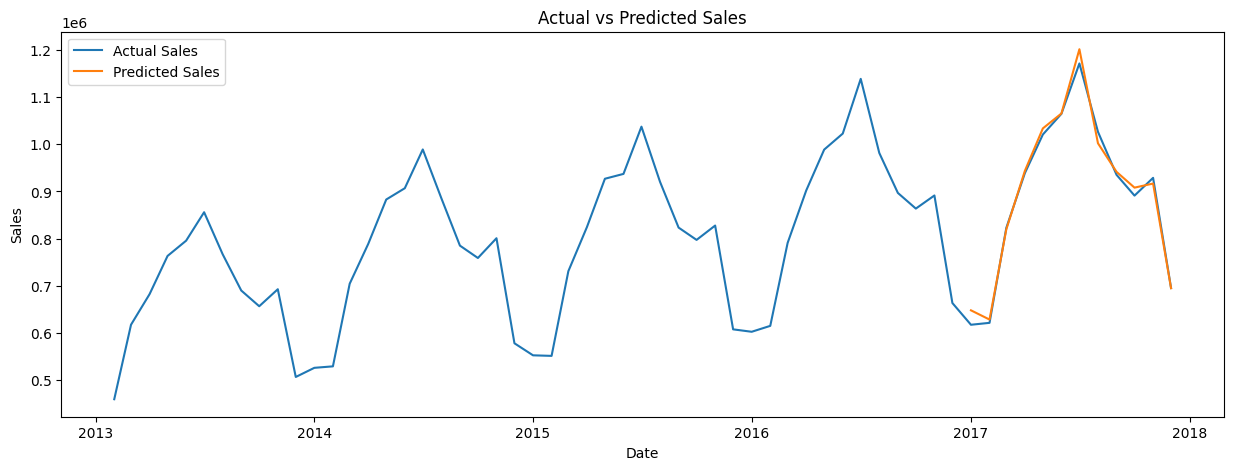

In [ ]:
# Visualization against actual sales
plt.figure(figsize=(15, 5))
plt.plot(monthly_sales['date'], monthly_sales['sales'], label='Actual Sales')
plt.plot(predict_df['date'], predict_df['Linear Prediction'], label='Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales')
plt.legend(['Actual Sales', 'Predicted Sales'])
plt.show()
